# Study case using DCN model

## Data pre-processing

In [24]:
import pandas as pd

import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# device = torch.device( "cpu")

In [2]:
#read dataset 
def read_custom_dataset(file_path):
    """
    Reads a custom formatted file where the first line represents column headers
    and the subsequent lines contain data, similar to a CSV.

    Parameters:
    file_path (str): The path to the file.

    Returns:
    DataFrame: A Pandas DataFrame containing the data from the file.
    """
    try:
        # Read the file into a DataFrame, assuming comma separation
        data = pd.read_csv(file_path, delimiter=",")
        return data
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")

# Example usage
file_path_test = '/users/Etu3/28600693/Documents/Rakuten_study_case/Interview Dataset Rakuten Advertising Test Set'  
file_path_train = '/users/Etu3/28600693/Documents/Rakuten_study_case/Interview Dataset Rakuten Advertising Train Set'  
test_dataset = read_custom_dataset(file_path_test)
train_dataset = read_custom_dataset(file_path_train)
print(test_dataset.head())
print(train_dataset.head())

                  date  zone_id  media_id  advertiser_id  campaign_id  \
0  2017-05-04 00:00:00     1117        89           1603         8015   
1  2017-05-07 00:00:00      366        48           1148         5742   
2  2017-05-04 00:00:00     2347        77           1605         8029   
3  2017-05-06 00:00:00      709        94           1603         8018   
4  2017-05-04 00:00:00     1122       101           1603         8015   

          domain  visibility  ad_id  width  height country_ref     device  \
0       arcor.de         1.0   9469    160     600          FR    firefox   
1            NaN         1.0   1453    800     250          DE  iosTablet   
2  visorando.com         NaN   5837   1000      90          FR    firefox   
3      orange.fr         NaN   4659    728      90          FR     safari   
4    outlook.com         NaN   9793    160     600          FR    firefox   

   imps  
0     1  
1     1  
2     1  
3     8  
4     8  
                  date  zone_id  media

In [3]:
def split_dataset(data):
    """
    Splits the dataset into features (X) and target (Y).

    Parameters:
    data (DataFrame): The Pandas DataFrame containing the dataset.

    Returns:
    X (DataFrame): The features of the dataset.
    Y (Series): The target variable of the dataset.
    """
    # Assuming 'clicks' is the target variable
    Y = data['clicks']
    X = data.drop('clicks', axis=1)
    return X, Y

# Assuming you have already read your dataset into a DataFrame named 'dataset'
X_train, Y_train = split_dataset(train_dataset)
X_test = test_dataset
X_train

,date,zone_id,media_id,advertiser_id,campaign_id,domain,visibility,ad_id,width,height,country_ref,device,imps
0,2017-05-02 00:00:00,2794,149,3206,16034,fatsecret.com,1.0,14885,250,250,US,safari,1
1,2017-05-06 00:00:00,879,77,1612,8060,sfrregie.com,NaN,7126,300,250,FR,firefox,2
2,2017-05-07 00:00:00,1321,119,2061,10306,alberghiera.it,2.0,11696,320,50,IT,iosPhone,1
3,2017-05-04 00:00:00,2347,77,1605,8029,visorando.com,NaN,5837,1000,90,FR,firefox,1
4,2017-05-02 00:00:00,931,90,1604,8023,pblv-plusbellelavie.fr,NaN,7414,300,250,FR,firefox,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395046,2017-05-02 00:00:00,397,47,1145,5729,meinestadt.de,NaN,1762,120,600,DE,firefox,1
5395047,2017-05-07 00:00:00,1076,87,1604,8021,funnykdo.com,NaN,9190,120,600,FR,ie,4
5395048,2017-05-05 00:00:00,969,100,1611,8059,yahoo.com,1.0,7209,300,250,FR,chrome,23
5395049,2017-05-03 00:00:00,2370,172,1632,8161,viamichelin.fr,2.0,7182,300,250,FR,chrome,2


In [4]:
Y_train[Y_train > 1].count()

55461

### Fill NaN data for X_train and test

In [5]:
# hangling missing values
numerical_columns = ['visibility', 'width', 'height', 'imps']
X_train[numerical_columns] = X_train[numerical_columns].fillna(X_train[numerical_columns].mean())

# Fill NaNs in categorical columns with a placeholder value (e.g., 'Unknown')
categorical_columns = X_train.select_dtypes(include=['object']).columns
X_train[categorical_columns] = X_train[categorical_columns].fillna('Unknown')

# Convert to datetime
X_train['date'] = pd.to_datetime(X_train['date'])

X_train['day_of_week'] = X_train['date'].dt.dayofweek
X_train['month'] = X_train['date'].dt.month
X_train['year'] = X_train['date'].dt.year
X_train['day'] = X_train['date'].dt.day

# drop date column
X_train = X_train.drop('date', axis=1)




# Fill NaNs in numerical columns with their mean
numerical_columns = ['visibility', 'width', 'height', 'imps']
X_test[numerical_columns] = X_test[numerical_columns].fillna(X_test[numerical_columns].mean())

# Fill NaNs in categorical columns with a placeholder value (e.g., 'Unknown')
categorical_columns = X_test.select_dtypes(include=['object']).columns
X_test[categorical_columns] = X_test[categorical_columns].fillna('Unknown')

# Convert to datetime
X_test['date'] = pd.to_datetime(X_test['date'])

X_test['day_of_week'] = X_test['date'].dt.dayofweek
X_test['month'] = X_test['date'].dt.month
X_test['year'] = X_test['date'].dt.year
X_test['day'] = X_test['date'].dt.day

# drop date column
X_test = X_test.drop('date', axis=1)


In [6]:
X_train

,zone_id,media_id,advertiser_id,campaign_id,domain,visibility,ad_id,width,height,country_ref,device,imps,day_of_week,month,year,day
0,2794,149,3206,16034,fatsecret.com,1.000000,14885,250,250,US,safari,1,1,5,2017,2
1,879,77,1612,8060,sfrregie.com,1.559608,7126,300,250,FR,firefox,2,5,5,2017,6
2,1321,119,2061,10306,alberghiera.it,2.000000,11696,320,50,IT,iosPhone,1,6,5,2017,7
3,2347,77,1605,8029,visorando.com,1.559608,5837,1000,90,FR,firefox,1,3,5,2017,4
4,931,90,1604,8023,pblv-plusbellelavie.fr,1.559608,7414,300,250,FR,firefox,1,1,5,2017,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395046,397,47,1145,5729,meinestadt.de,1.559608,1762,120,600,DE,firefox,1,1,5,2017,2
5395047,1076,87,1604,8021,funnykdo.com,1.559608,9190,120,600,FR,ie,4,6,5,2017,7
5395048,969,100,1611,8059,yahoo.com,1.000000,7209,300,250,FR,chrome,23,4,5,2017,5
5395049,2370,172,1632,8161,viamichelin.fr,2.000000,7182,300,250,FR,chrome,2,2,5,2017,3


In [7]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
Y_train_copy = Y_train.copy()
original_imps_train_tensor = torch.tensor(X_train['imps'], dtype=torch.float32).to(device)
original_clicks_train_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)
original_imps_test_tensor = torch.tensor(X_test['imps'], dtype=torch.float32).to(device)
original_imps_test = X_test['imps']

In [8]:
from sklearn.preprocessing import StandardScaler

numerical_columns = ['visibility', 'width', 'height']
# Applying standard scaler
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])


# Applying standard scaler
X_test[numerical_columns] = scaler.fit_transform(X_test[numerical_columns])

#  Applying stadard scaler on Y_train
# scaler_y = StandardScaler()
# Y_train_scaled = scaler_y.fit_transform(Y_train.values.reshape(-1, 1))

# Save the scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')
# joblib.dump(scaler_y, 'scaler_y.pkl')

# scaler_imps = StandardScaler()
# X_train['imps'] = scaler_imps.fit_transform(X_train['imps'].values.reshape(-1, 1))
# X_test['imps'] = scaler_imps.fit_transform(X_test['imps'].values.reshape(-1, 1)) 

['scaler.pkl']

In [9]:

label_encoders = {}
categorical_columns = ['zone_id', 'media_id', 'advertiser_id', 'campaign_id', 'domain', 'ad_id', 'country_ref', 'device', 'day_of_week', 'month', 'day', 'year']
for col in categorical_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].values)
    label_encoders[col] = le  # Store each encoder


# label encoder for X_test
label_encoders_test = {}
for col in categorical_columns:
    le = LabelEncoder()
    X_test[col] = le.fit_transform(X_test[col].values)
    label_encoders_test[col] = le  # Store each encoder

X_train.head()  

,zone_id,media_id,advertiser_id,campaign_id,domain,visibility,ad_id,width,height,country_ref,device,imps,day_of_week,month,year,day
0,2777,148,114,488,24838,-1.571073e+00,14796,-0.654911,-0.100689,11,12,1,1,0,0,1
1,875,76,44,185,64544,1.246758e-15,7103,-0.481482,-0.100689,7,5,2,5,0,0,5
2,1317,118,107,455,2769,1.236378e+00,11661,-0.412110,-1.046189,9,8,1,6,0,0,6
3,2332,76,37,154,77524,1.246758e-15,5820,1.946528,-0.857089,7,5,1,3,0,0,3
4,927,89,36,148,55087,1.246758e-15,7390,-0.481482,-0.100689,7,5,1,1,0,0,1


In [10]:
class CustomLoss(nn.Module):
    def __init__(self,eps = 1e-6):
        super(CustomLoss, self).__init__()
        self.eps = eps
    
    def __check_data_validity(self, pred_clicks, clicks, imps):
        assert torch.all(clicks >= 0) and torch.all(clicks <= imps), "Clicks must be non-negative and less than or equal to impressions"
        assert torch.all(imps > 0), "Impressions must be greater than zero to avoid division by zero in loss calculation"

        assert not torch.isnan(pred_clicks).any(), "NaNs in pred_clicks"
        assert not torch.isnan(clicks).any(), "NaNs in clicks"
        assert not torch.isnan(imps).any(), "NaNs in imps"

        assert torch.all(pred_clicks >= 0), "Negative values in pred_clicks"
        assert torch.all(imps > 0), "Non-positive values in imps"




    def forward(self, pred_clicks, clicks, imps):
        """
        y_pred: The predicted CTR for each example, a tensor of shape (n_examples, 1).
        clicks: The actual clicks for each example, a tensor of shape (n_examples, 1).
        imps: The number of impressions for each example, a tensor of shape (n_examples, 1).
        """
        # assert things are not none or nan
        self.__check_data_validity(pred_clicks, clicks, imps)
        # Calculating the predicted CTR
        y_pred = pred_clicks / imps
        

        # check theres no nan or inf in y_pred
        assert torch.isfinite(y_pred).all() # Check for NaN or Inf values
        assert torch.all(y_pred >= 0) #and torch.all(y_pred <= 1) # CTR must be between 0 and 1
        # Clip the predicted CTR to avoid log(0)
        y_pred = torch.clamp(y_pred, self.eps, 1 - self.eps)


        

        #torch.clamp(y_pred, self.eps, 1 - self.eps)
      
        # print(f"y_pred{y_pred.shape}")
        # print(f"clicks{clicks.shape}")
        # print(f"imps{imps.shape}")
        # Calculating the log loss component
        log_loss = clicks * torch.log(y_pred + self.eps) + (imps - clicks) * torch.log(1 - y_pred + self.eps)
        # print(torch.log(y_pred + self.eps))
        
        # Normalizing by the number of impressions
        loss = -torch.sum(log_loss / torch.sum(imps))
        return loss

In [11]:
# Identify categorical and continuous columns
categorical_columns = ['zone_id', 'media_id', 'advertiser_id', 'campaign_id', 'domain', 'ad_id', 'country_ref', 'device', 'day_of_week', 'month', 'day', 'year']
continuous_columns = ['visibility', 'width', 'height', 'imps']



# Separate sparse and dense features
sparse_features = X_train[categorical_columns].values
dense_features = X_train[continuous_columns].values

# Convert to tensors

# sparse_features = torch.tensor(sparse_features, dtype=torch.long)
# dense_features = torch.tensor(dense_features, dtype=torch.float)

X_train_categorical = torch.tensor(X_train[categorical_columns].values, dtype=torch.long).to(device)
X_train_continuous = torch.tensor(X_train[continuous_columns].values, dtype=torch.float).to(device)
# Y_train_tensor = torch.tensor(Y_train_scaled, dtype=torch.float).view(-1, 1)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float).view(-1, 1)
Y_train_tensor = torch.clamp(Y_train_tensor, min = 0, max = 1)
Y_train_tensor = Y_train_tensor.to(device)

In [12]:
sparse_features.shape

(5395051, 12)

In [13]:
dense_features.shape

(5395051, 4)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CrossNetwork(nn.Module):
    def __init__(self, input_dim, num_layers):
        super(CrossNetwork, self).__init__()
        self.num_layers = num_layers
        self.cross_weights = nn.ParameterList([nn.Parameter(torch.randn(input_dim, 1)) for _ in range(num_layers)])
        self.cross_bias = nn.ParameterList([nn.Parameter(torch.randn(input_dim)) for _ in range(num_layers)])

    def forward(self, x):
        x0 = x
        for i in range(self.num_layers):
            x = torch.matmul(x0, self.cross_weights[i]) + self.cross_bias[i] + x
        return x

class DCN(nn.Module):
    def __init__(self, categorical_feature_sizes, continuous_feature_size, embedding_size, hidden_layers, cross_layers):
        super(DCN, self).__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(num_features, embedding_size) for num_features in categorical_feature_sizes])
        total_embedding_size = len(categorical_feature_sizes) * embedding_size
        self.input_dim = total_embedding_size + continuous_feature_size

        # Cross Network
        self.cross_network = CrossNetwork(self.input_dim, cross_layers)

        # Deep Network
        deep_layers = [self.input_dim] + hidden_layers
        self.deep_network = nn.ModuleList([nn.Linear(deep_layers[i], deep_layers[i + 1]) for i in range(len(deep_layers) - 1)])
        self.dropout = nn.Dropout(0.5)

        # Final Linear Layer
        self.final_linear = nn.Linear(deep_layers[-1] + self.input_dim, 1)

    def forward(self, x_categorical, x_continuous):
        embeddings = [self.embeddings[i](x_categorical[:, i]) for i in range(len(self.embeddings))]
        embeddings = torch.cat(embeddings, dim=1)
        x = torch.cat([embeddings, x_continuous], dim=1)

        # Cross Network
        x_cross = self.cross_network(x)

        # Deep Network
        x_deep = x
        for layer in self.deep_network:
            x_deep = F.relu(layer(x_deep))
            x_deep = self.dropout(x_deep)

        # Combine
        x_combined = torch.cat([x_cross, x_deep], dim=1)
        return torch.sigmoid(self.final_linear(x_combined))

In [15]:
categorical_feature_sizes = [X_train[col].nunique() for col in categorical_columns]
continuous_feature_size = len(continuous_columns)
embedding_size = 12
hidden_layers = [100, 50]  
cross_layers = 4 

model = DCN(categorical_feature_sizes, continuous_feature_size, embedding_size, hidden_layers, cross_layers)

In [18]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim


# X_train_categorical, X_train_continuous, and Y_train are tensors
train_data = TensorDataset(X_train_categorical, X_train_continuous, Y_train_tensor)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

# Initialize the model
model = DCN(categorical_feature_sizes, continuous_feature_size, embedding_size, hidden_layers, cross_layers)
model.to(device)  # Move model to appropriate device (CPU or GPU)

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_curve = []
print("running device : ",device)
# Training Loop
num_epochs = 5  # Number of training epochs
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0

    for batch in train_loader:
        # Unpack the batch
        categorical, continuous, targets = batch
        categorical, continuous, targets = categorical.to(device), continuous.to(device), targets.to(device)
    
        # Forward pass
        optimizer.zero_grad()
        outputs = model(categorical, continuous).view(-1)

        # Compute loss
        loss = criterion(outputs, targets.view(-1))
        train_loss += loss.item()

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    # Print average loss for the epoch
    avg_loss = train_loss / len(train_loader)
    loss_curve.append(avg_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

# save the model
torch.save(model.state_dict(), 'DCNmodel_CTRclicklabel.pth')


2024-03-25 05:47:16.428830: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 05:47:16.555355: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-25 05:47:18.008144: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /Infos/lmd/2021/licence/ue/LU3IN029-2021oct/kO6/bin/gcc/lib64:/Infos/lmd/2021/licence/ue/LU3IN029-2021oct/kO6/bin/gcc/lib64::/opt/gurobi801/linux64/lib:/opt/gurobi801/linux64/lib
2024-03-25 05:47:18.008368: W ten

running device :  cuda
Epoch [1/5], Loss: 0.1061
Epoch [2/5], Loss: 0.0956
Epoch [3/5], Loss: 0.0941
Epoch [4/5], Loss: 0.0938
Epoch [5/5], Loss: 0.0937


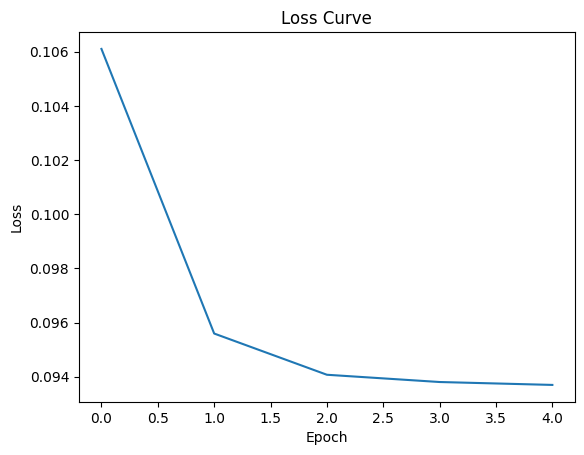

In [19]:
plt.plot(loss_curve)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

In [16]:
# Load model if exists
model = DCN(categorical_feature_sizes, continuous_feature_size, embedding_size, hidden_layers, cross_layers)
model.load_state_dict(torch.load('DCNmodel_CTRclicklabel.pth'))   
model.to(device)

DCN(
  (embeddings): ModuleList(
    (0): Embedding(2910, 12)
    (1): Embedding(187, 12)
    (2): Embedding(119, 12)
    (3): Embedding(503, 12)
    (4): Embedding(82016, 12)
    (5): Embedding(15184, 12)
    (6): Embedding(12, 12)
    (7): Embedding(17, 12)
    (8): Embedding(7, 12)
    (9): Embedding(1, 12)
    (10): Embedding(8, 12)
    (11): Embedding(1, 12)
  )
  (cross_network): CrossNetwork(
    (cross_weights): ParameterList(
        (0): Parameter containing: [torch.float32 of size 148x1]
        (1): Parameter containing: [torch.float32 of size 148x1]
        (2): Parameter containing: [torch.float32 of size 148x1]
        (3): Parameter containing: [torch.float32 of size 148x1]
    )
    (cross_bias): ParameterList(
        (0): Parameter containing: [torch.float32 of size 148]
        (1): Parameter containing: [torch.float32 of size 148]
        (2): Parameter containing: [torch.float32 of size 148]
        (3): Parameter containing: [torch.float32 of size 148]
    )
  )


In [17]:
from cgi import test


X_test_categorical = torch.tensor(X_test[categorical_columns].values, dtype=torch.long).to(device)
X_test_continuous = torch.tensor(X_test[continuous_columns].values, dtype=torch.float).to(device)




test_data = TensorDataset(X_test_categorical, X_test_continuous)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)


# original_imps_test = scaler_imps.inverse_transform(X_test['imps'].values.reshape(-1, 1))
# original_imps_test = original_imps_test.flatten()

model.eval()
with torch.no_grad():
    predictions = model(X_test_categorical, X_test_continuous).cpu().numpy()

# Assuming you have original_imps_test ready (inverse transformed if needed)
# clicks_pred = scaler_y.inverse_transform(predictions)
ctr = predictions.flatten()
ctr= np.round(ctr, 2)

# clicks_pred = predictions.flatten()



# Save the predictions as csv
ctr = pd.DataFrame({'ctr': ctr})



ctr.to_csv('click_label_ctr.csv', index=False)

# Add predicted ctr to the test dataset
X_test_copy['ctr'] = ctr
X_test_copy.to_csv('X_test_click_label_ctr.csv') 

In [18]:
print(ctr[ctr >0].count())
print(ctr[ctr ==1.].count())
print(len(ctr))

ctr    1439133
dtype: int64
ctr    132443
dtype: int64
2019086


## Evaluation using loss metrics

In [21]:
X_train

,zone_id,media_id,advertiser_id,campaign_id,domain,visibility,ad_id,width,height,country_ref,device,imps,day_of_week,month,year,day
0,2777,148,114,488,24838,-1.571073e+00,14796,-0.654911,-0.100689,11,12,1,1,0,0,1
1,875,76,44,185,64544,1.246758e-15,7103,-0.481482,-0.100689,7,5,2,5,0,0,5
2,1317,118,107,455,2769,1.236378e+00,11661,-0.412110,-1.046189,9,8,1,6,0,0,6
3,2332,76,37,154,77524,1.246758e-15,5820,1.946528,-0.857089,7,5,1,3,0,0,3
4,927,89,36,148,55087,1.246758e-15,7390,-0.481482,-0.100689,7,5,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395046,394,46,16,71,46011,1.246758e-15,1752,-1.105827,1.553937,5,5,1,1,0,0,1
5395047,1072,86,36,146,28134,1.246758e-15,9159,-1.105827,1.553937,7,7,4,6,0,0,6
5395048,965,99,43,184,80972,-1.571073e+00,7186,-0.481482,-0.100689,7,3,23,4,0,0,4
5395049,2355,171,64,284,76992,1.236378e+00,7159,-0.481482,-0.100689,7,3,2,2,0,0,2


In [22]:
def train(model, train_loader, val_loader, criterion_train, criterion_val,optimizer, num_epochs):
    train_loss_curve = []
    val_loss_curve = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        train_loss = 0

        for batch in train_loader:
            # Unpack the batch
            categorical, continuous, targets = batch
            categorical, continuous, targets = categorical.to(device), continuous.to(device), targets.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(categorical, continuous).view(-1)

            # Compute loss
            loss = criterion_train(outputs, targets.view(-1))
            train_loss += loss.item()

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
        
        # Print average loss for the epoch
        avg_loss = train_loss / len(train_loader)
        train_loss_curve.append(avg_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_loss:.4f}')

        # Validation
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                # Unpack the batch
                X_val_categorical, X_val_continuous, original_clicks_val_tensor, original_val_imps_tensor = batch
                categorical, continuous, targets = categorical.to(device), continuous.to(device), targets.to(device)

                # Forward pass
                ctr = model(X_val_categorical, X_val_continuous).view(-1)

                # treat predicted ctr 
                ctr= np.round(ctr.cpu().numpy(), 2)
                ctr= torch.tensor(ctr, dtype=torch.float).view(-1, 1).to(device)
                ctr = ctr.to(device)
        
                # Compute loss
                loss = criterion_val(ctr, original_clicks_val_tensor.flatten(), original_val_imps_tensor.flatten())
                val_loss += loss.item()

        # Print average loss for the epoch
        avg_loss = val_loss / len(val_loader)
        val_loss_curve.append(avg_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_loss:.4f}')

    return train_loss_curve, val_loss_curve










In [26]:
from sklearn.model_selection import KFold

metrics = []
i =0
kf = KFold(n_splits=4)
for train_index, val_index in kf.split(X_train.values) : 
    

    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = Y_train.iloc[train_index], Y_train.iloc[val_index]
    
    # Convert to tensors
    X_train_categorical = torch.tensor(X_train_fold[categorical_columns].values, dtype=torch.long).to(device)
    X_train_continuous = torch.tensor(X_train_fold[continuous_columns].values, dtype=torch.float).to(device)
    Y_train_tensor = torch.tensor(y_train_fold.values, dtype=torch.float).view(-1, 1)
    Y_train_tensor = torch.clamp(Y_train_tensor, min = 0, max = 1)
    Y_train_tensor = Y_train_tensor.to(device)

    X_val_categorical = torch.tensor(X_val_fold[categorical_columns].values, dtype=torch.long).to(device)
    X_val_continuous = torch.tensor(X_val_fold[continuous_columns].values, dtype=torch.float).to(device)
    Y_val_tensor = torch.tensor(y_val_fold.values, dtype=torch.float).view(-1, 1)
    Y_val_tensor = torch.clamp(Y_val_tensor, min = 0, max = 1)
    Y_val_tensor = Y_val_tensor.to(device)
    
    original_val_imps_tensor = torch.tensor(X_val_fold['imps'].values, dtype=torch.float).view(-1, 1).to(device)

    train_data = TensorDataset(X_train_categorical, X_train_continuous, Y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

    val_data = TensorDataset(X_val_categorical, X_val_continuous, Y_val_tensor, original_val_imps_tensor)
    val_loader = DataLoader(val_data, batch_size=128, shuffle=False)

    model = DCN(categorical_feature_sizes, continuous_feature_size, embedding_size, hidden_layers, cross_layers)
    model.to(device)  # Move model to appropriate device (CPU or GPU)

    criterion_train = nn.BCELoss()
    criterion_val = CustomLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    print(f"Training model... Fold {i + 1}")
    train_loss_curve, val_loss_curve = train(model, train_loader, val_loader, criterion_train, criterion_val, optimizer, num_epochs=3)

    metrics.append((train_loss_curve, val_loss_curve))
    i+=1




    


Training model... Fold 1
Epoch [1/3], Training Loss: 0.1062
Epoch [1/3], Validation Loss: 16.3310
Epoch [2/3], Training Loss: 0.0987
Epoch [2/3], Validation Loss: 18.4465
Epoch [3/3], Training Loss: 0.0977
Epoch [3/3], Validation Loss: 15.9353
Training model... Fold 2
Epoch [1/3], Training Loss: 0.1091
Epoch [1/3], Validation Loss: 16.2062
Epoch [2/3], Training Loss: 0.0977
Epoch [2/3], Validation Loss: 16.8740
Epoch [3/3], Training Loss: 0.0962
Epoch [3/3], Validation Loss: 16.3792
Training model... Fold 3
Epoch [1/3], Training Loss: 0.1054
Epoch [1/3], Validation Loss: 15.0838
Epoch [2/3], Training Loss: 0.0979
Epoch [2/3], Validation Loss: 17.7382
Epoch [3/3], Training Loss: 0.0968
Epoch [3/3], Validation Loss: 16.9426
Training model... Fold 4
Epoch [1/3], Training Loss: 0.1059
Epoch [1/3], Validation Loss: 17.8870
Epoch [2/3], Training Loss: 0.0979
Epoch [2/3], Validation Loss: 15.9330
Epoch [3/3], Training Loss: 0.0964
Epoch [3/3], Validation Loss: 16.0570


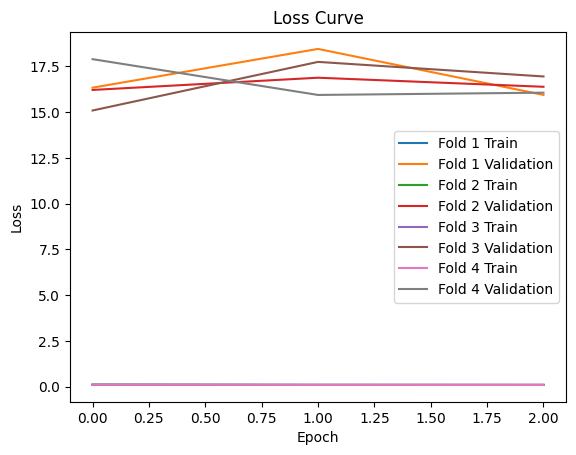

In [27]:
# Plot metrics 
for i, (train_loss_curve, val_loss_curve) in enumerate(metrics):
    plt.plot(train_loss_curve, label=f'Fold {i + 1} Train')
    plt.plot(val_loss_curve, label=f'Fold {i + 1} Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()
